In [1]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# custom libraries used
from models.grid_world import Experiment
from models.agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent, MetaAgent
from models.experiment_designs.experiment1 import gen_task_param
sns.set_context('paper', font_scale=1.5)

In [2]:
n_sims = 115

# alpha is sample from the distribution
# log(alpha) ~ N(alpha_mu, alpha_scale)
alpha_mu = 0.0
alpha_scale = 1.0

inv_temp = 10.0
goal_prior = 10e-20 
prunning_threshold = 10.0
evaluate = False

np.random.seed(0)

# pre generate a set of tasks for consistency. 
list_tasks = [gen_task_param() for _ in range(n_sims)]

# pre draw the alphas for consistency
list_alpha = [np.exp(scipy.random.normal(loc=alpha_mu, scale=alpha_scale)) 
              for _ in range(n_sims)]

def sim_agent(AgentClass, name='None', flat=False, meta=False):
    results = []
    for ii, (task_args, task_kwargs) in tqdm(enumerate(list_tasks), total=len(list_tasks)):

        if not flat:
            agent_kwargs = dict(alpha=list_alpha[ii], inv_temp=inv_temp, 
                                goal_prior=goal_prior)
        else:
            agent_kwargs = dict(inv_temp=inv_temp, goal_prior=goal_prior)
            
        if meta:
            agent_kwargs['mix_biases'] = [np.random.uniform(-3, 0), np.random.uniform(-3, 0)]
        
        agent = AgentClass(Experiment(*task_args, **task_kwargs), **agent_kwargs)
        
        _res = agent.generate(evaluate=evaluate, prunning_threshold=prunning_threshold)
        _res[u'Model'] = name
        _res[u'Iteration'] = [ii] * len(_res)
        results.append(_res)
    return pd.concat(results)

In [3]:
results_meta = sim_agent(MetaAgent, name='Meta', meta=True)
results_ic = sim_agent(IndependentClusterAgent, name='Independent')
results_jc = sim_agent(JointClusteringAgent, name='Joint')
results_fl = sim_agent(FlatAgent, name='Flat', flat=True)
results = pd.concat([results_ic, results_jc, results_fl, results_meta])

100%|██████████| 115/115 [08:14<00:00,  4.30s/it]
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


## Model Predictions
Summary Statistics:

In [4]:
results['Training'] = results.Context < 5
results['Acc'] = pd.to_numeric(results.Reward)
results[results['In Goal']].groupby(['Training', 'Model']).mean()

Context  In Goal  Ind Weight  Iteration  \
Training Model                                                   
False    Flat         6.166667     True         NaN       57.0   
         Independent  6.166667     True         NaN       57.0   
         Joint        6.166667     True         NaN       57.0   
         Meta         6.166667     True  -32.249517       57.0   
True     Flat         2.750000     True         NaN       57.0   
         Independent  2.750000     True         NaN       57.0   
         Joint        2.750000     True         NaN       57.0   
         Meta         2.750000     True  -15.477518       57.0   

                      Joint Probability  Joint Weight  Key-press  Steps Taken  \
Training Model                                                                  
False    Flat                       NaN           NaN   3.483768     6.711594   
         Independent                NaN           NaN   3.470435     5.123188   
         Joint                      NaN           NaN   3.489855     6.068696   
         Meta                  0.480950    -31.799966   3.484928     5.650435   
True     Flat                       NaN           NaN   3.486014     5.280942   
         Independent                NaN           NaN   3.476884     5.067464   
         Joint                      NaN           NaN   3.486449     5.195580   
         Meta                  0.434537    -15.711474   3.489928     5.135507   

                      Times Seen Context  Trial Number       Acc  
Training Model                                                    
False    Flat                   4.666667         134.5  0.857391  
         Independent            4.666667         134.5  0.802899  
         Joint                  4.666667         134.5  0.832754  
         Meta                   4.666667         134.5  0.826377  
True     Flat                  16.333333          59.5  0.953551  
         Independent           16.333333          59.5  0.926667  
         Joint                 16.333333          59.5  0.943696  
         Meta                  16.333333          59.5  0.942609

Plot the overall rewards collected in the training and test contexts

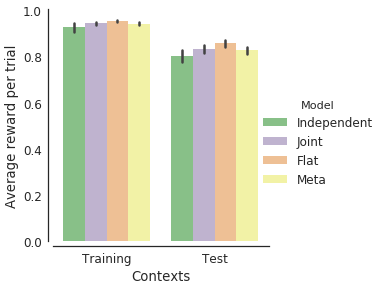

In [5]:
in_goal = results[results['In Goal'] ].copy()
in_goal['Contexts'] = [None] * len(in_goal)
in_goal.loc[in_goal.Context < 5, 'Contexts'] = 'Training'
in_goal.loc[in_goal.Context >= 5, 'Contexts'] = 'Test'

with sns.axes_style('white'):
    g = sns.factorplot(y='Reward', data=in_goal, x='Contexts', 
                   hue='Model', units='Iteration', kind='bar', 
                   estimator=np.mean, palette='Accent', size=4)
    sns.despine(offset=5, trim=False)
    ax = g.axes[0][0]
    ax.set_ylabel('Average reward per trial')

Break down the accuracy in each test context

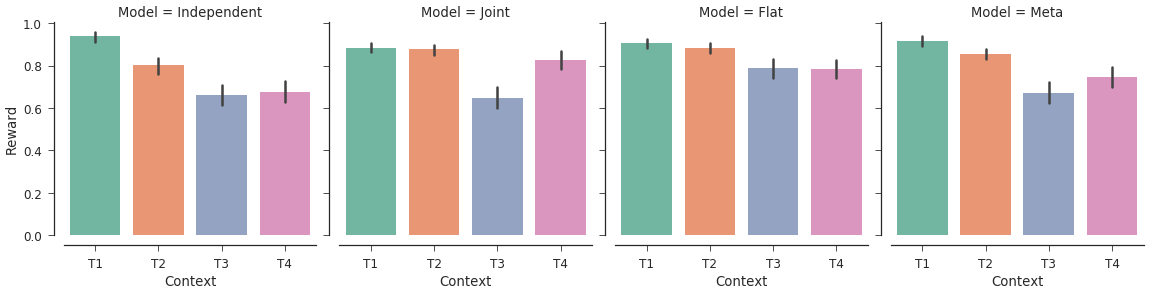

In [6]:
with sns.axes_style('ticks'):
    g = sns.factorplot(x='Context', y='Reward', data=in_goal[in_goal['Contexts'] == 'Test'], 
                   kind='bar', palette='Set2', col='Model', units='Iteration')
    g.set_xticklabels(['T1', 'T2', 'T3', 'T4'])
    sns.despine(offset=10)
    

# Paper Figure
*Left*: Reward collected in test contexts across time

*Right*: Difference in reward collect between contexts across equated trials

In [7]:

### calculate the differences scores for each condition

df0 = results[results['In Goal'] & (results.Context > 4) & (results['Times Seen Context'] <= 5) &
              (results['Model'] != 'Flat')
             ].copy()
score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 5, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 6, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2/4'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T2/4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T2 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
score = pd.concat(score) 

# df0 = results[results['In Goal'] & (results.Context >= 4) & 
#               (results['Times Seen Context'] < 6) ].copy()
df0['Context'] += 1
# df0


In [8]:
### define a plotting function to display the test results

from matplotlib import gridspec
from scipy.stats import ttest_1samp

def plot_test_overtime(model_name, ax):
    # plot the results over time
    sns.pointplot(x='Times Seen Context', hue='Context', y='Reward', ci=None,
                  data=df0[df0.Model==model_name],  palette='Set2', ax=ax)

    # plot the collapsed difference scores
    ax.legend_.remove() 
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)

    ax.set_xticklabels([1, 2, 3, 4, 5])
    ax.set_ylabel(r'Accuracy')
    ax.plot([0, 5], [0.25, 0.25], 'k:')
    ax.set_ylim([0, 1])
    ax.set_title(model_name)
    sns.despine(offset=5, ax=ax)
    
def plot_test_difference_score(model_name, ax):
    sns.barplot(x='Comparison', y='Difference Score',
                data=score[score.Model == model_name], color='skyblue', ax=ax)
    ax.set_ylabel(r'Difference Score', labelpad=-3)
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    sns.despine(offset=5, ax=ax)
    plt.sca(ax)
    plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical',
               fontsize='small')

    
def print_diff_stats(model_name):
    diff = score.groupby(['Model', 'Comparison','Iteration']).mean().reset_index()
    for c in set(score.Comparison):
        selection = (diff.Model == model_name) &(diff.Comparison == c)
        t, p = ttest_1samp(diff.loc[selection, 'Difference Score'].values, 0)
        df = len(diff.loc[selection, 'Difference Score'].values)
        M = np.mean(diff.loc[selection, 'Difference Score'].values)
        print "%s: M=%.3g, t(%d)=%.5g, p=%.3g" % (c, M, df, t, p)
        
def plot_test(model_name):
    with sns.axes_style('ticks'):
        fig  = plt.figure(figsize=(5.5, 3))
        gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.3)
        axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]

        plot_test_overtime(model_name, ax=axes[0])
        plot_test_difference_score(model_name, ax=axes[1])
        
        print_diff_stats(model_name) 

/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


T3 vs T2/4: M=-0.142, t(115)=-6.4253, p=3.16e-09
T1 vs T2/4: M=-0.0217, t(115)=-1.2579, p=0.211
T2 vs T4: M=-0.0748, t(115)=-3.9594, p=0.000131


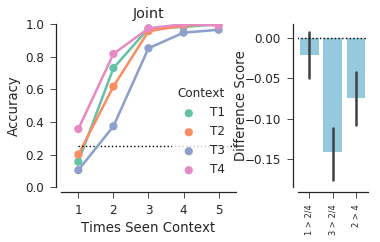

In [9]:
plot_test("Joint")

T3 vs T2/4: M=0.00174, t(115)=0.11029, p=0.912
T1 vs T2/4: M=0.233, t(115)=11.553, p=6.55e-21
T2 vs T4: M=-0.0313, t(115)=-1.7311, p=0.0861


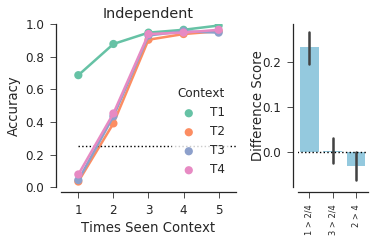

In [10]:
plot_test("Independent")

T3 vs T2/4: M=-0.0565, t(115)=-2.7999, p=0.00601
T1 vs T2/4: M=0.107, t(115)=4.6573, p=8.73e-06
T2 vs T4: M=-0.04, t(115)=-1.8926, p=0.0609


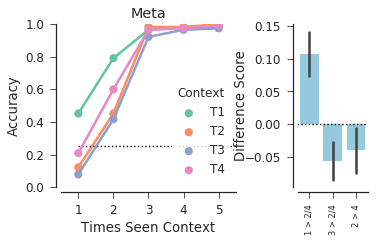

In [11]:
plot_test("Meta")

# Figures for paper
These are the figure used in the paper draft

In [12]:
#within subject errorbars (standard error)

cc = sns.color_palette('Set2')
def plot_test_context(m, c, ax, color, label):
    ctx = df0.loc[(df0['Times Seen Context'] < 6) & (df0['Context'] == c) & 
                  (df0['Model'] == m), 'Reward'
                ].values.reshape(n_sims, -1)
    ctx_std_err = np.array(ctx - np.tile(ctx.mean(axis=1), (5, 1)).T +\
                           np.tile(ctx.mean(), np.shape(ctx)),dtype='float').std(axis=0) / np.sqrt(n_sims)

    plt.plot(range(1, 6), ctx.mean(axis=0), color=color, label=label,
                linewidth=0, marker='.', markersize=15)
    (_, caps, _) = plt.errorbar(range(1, 6), ctx.mean(axis=0), ctx_std_err, color=color,
                linewidth=3)
    
def plot_model_test_context(model):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(3,3))
        plot_test_context(model, 6, ax, cc[0], 'T1')
        plot_test_context(model, 7, ax, cc[1], 'T2')
        plot_test_context(model, 8, ax, cc[2], 'T3')
        plot_test_context(model, 9, ax, cc[3], 'T4')
        legend = ax.legend(title="Context", loc='lower right', frameon=1, fontsize=12)
        legend.get_frame().set_edgecolor('w')
        ax.get_legend().get_title().set_fontsize(12)
        ax.set_xticks(range(1, 6))
        ax.set_xlabel('Times Seen Context', fontsize=15)
        ax.set_ylabel('Accuracy', fontsize=15)
        ax.plot([1, 5], [1./3, 1./3], 'k:')
        ax.set_ylim([0, 1])
        plt.title(model, fontsize=18, fontname='Helvetica')
        sns.despine(offset=5)

/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/sit

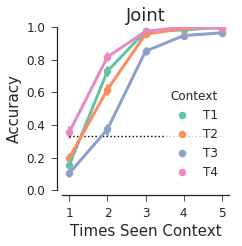

In [13]:
plot_model_test_context('Joint')
plt.savefig('Exp1_fig1b.png', dpi=300, bbox_inches='tight')

/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/sit

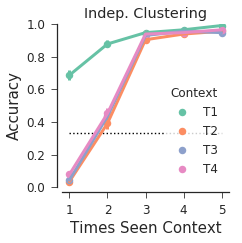

In [14]:
plot_model_test_context('Independent')
plt.title('Indep. Clustering')
plt.savefig('Exp1_fig1a.png', dpi=300, bbox_inches='tight')

/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/sit

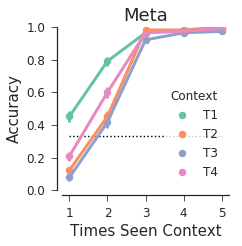

In [15]:
plot_model_test_context('Meta')

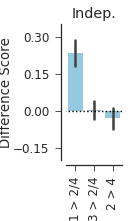

In [16]:
with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(1.0, 2.5))    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', units='Iteration',
            data=score[score.Model == 'Independent'], color='skyblue', ax=ax)
    ax.set_ylabel(r'Difference Score', labelpad=0)#, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_ylim([-0.20, 0.351])
    ax.set_yticks(np.arange(-0.15, 0.31, 0.15))
    sns.despine(offset=5)
    
    plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
    ax.set_title(r'Indep.')


    plt.savefig('Exp1_fig1d.png', dpi=300, bbox_inches='tight')

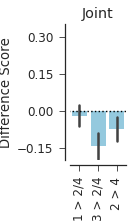

In [17]:
with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(1.0, 2.5))    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', units='Iteration',
            data=score[score.Model == 'Joint'], color='skyblue', ax=ax)
    ax.set_ylabel(r'Difference Score')#, labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_ylim([-0.20, 0.351])
    ax.set_yticks(np.arange(-0.15, 0.31, 0.15))
    sns.despine(offset=5)
    plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
    ax.set_title(r'Joint')

    plt.savefig('Exp1_fig1e.png', dpi=300, bbox_inches='tight')
    

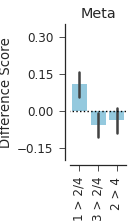

In [18]:
with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(1.0, 2.5))    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', units='Iteration',
            data=score[score.Model == 'Meta'], color='skyblue', ax=ax)
    ax.set_ylabel(r'Difference Score')#, labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_ylim([-0.20, 0.351])
    ax.set_yticks(np.arange(-0.15, 0.31, 0.15))
    sns.despine(offset=5)
    plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
    ax.set_title(r'Meta')


    plt.savefig('Exp1_fig1f.png', dpi=300, bbox_inches='tight')
    

## Plot the meta-agent weights overtime

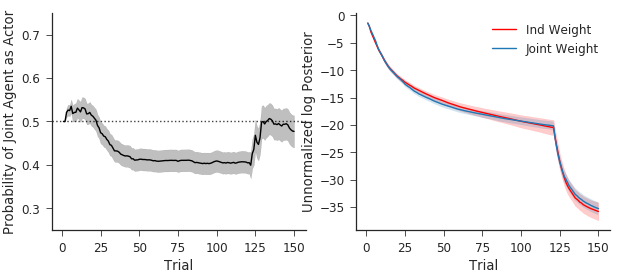

In [19]:
from matplotlib.ticker import NullFormatter


with sns.axes_style('ticks'):

    df0 = results[(results['Steps Taken']==1) & 
                  (results['Model'] == 'Meta')
                 ].copy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    x = range(1, int(df0['Trial Number'].max()) + 2)
    y = df0.groupby('Trial Number')['Joint Probability'].mean()
    y_err = df0.groupby('Trial Number')['Joint Probability'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'k-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.25, color='k')
    ax.set_ylabel('Probability of Joint Agent as Actor')
    ax.set_xlabel('Trial')
    xlb, xub = ax.get_xlim()
    ax.plot([xlb, xub], [0.5, 0.5], 'k:', alpha=0.75)
    ax.set_xlim(xlb, xub)
    ax.set_ylim([0.25, 0.75])

    ax = axes[1]
    y = df0.groupby('Trial Number')['Ind Weight'].mean()
    y_err = df0.groupby('Trial Number')['Ind Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'r-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2, color='r')

    y = df0.groupby('Trial Number')['Joint Weight'].mean()
    y_err = df0.groupby('Trial Number')['Joint Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, '-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)
    plt.legend(loc='best')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Unnormalized log Posterior')    
    ax.set_xlim(xlb, xub)

    plt.subplots_adjust(hspace=0.3)
    sns.despine()
    plt.savefig('Exp1_supp_weights.png', dpi=300)